# Simple GRU Model

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import GRU, Dense, Input, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [2]:
# Load the dataset
train_x = pd.read_csv('/Users/mohanyang/Documents/GitHub/SUROP_time_series/SUROP/data/train_x.csv')
train_y = pd.read_csv('/Users/mohanyang/Documents/GitHub/SUROP_time_series/SUROP/data/train_y.csv')
test_x = pd.read_csv('/Users/mohanyang/Documents/GitHub/SUROP_time_series/SUROP/data/test_x.csv')

In [3]:
# Display the first few rows
print(train_x.head())
print(train_x.shape)

   Hour  ID    Age  Gender  Unit1  Unit2     HR   O2Sat   Temp     SBP  ...  \
0     1   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
1     2   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
2     3   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
3     4   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
4     5   2  66.67     1.0    0.0    1.0  84.42   99.58  35.61  114.60  ...   

   Phosphate  Potassium  Bilirubin_total  TroponinI    Hct   Hgb  PTT   WBC  \
0        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
1        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
2        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
3        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
4        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   

   Fibrinogen  Platelets  
0         NaN        Na

In [4]:
print(train_y.head())
print(train_y.shape)

   ID  Outcome
0   2        0
1   3        0
2   5        1
3   6        0
4  13        0
(12115, 2)


In [5]:
max_hours = train_x.groupby('ID')['Hour'].count().max()
print(f'Maximum number of hours: {max_hours}')

Maximum number of hours: 336


In [6]:
# Get unique person IDs
person_ids = train_x['ID'].unique()

# Initialize tensors for features, masks, and time intervals
num_persons = len(person_ids)
num_features = train_x.shape[1] - 2  # excluding 'ID' and 'Hour' columns

In [7]:
person_ids

array([    2,     3,     5, ..., 21630, 21632, 21633])

In [8]:
#Initialize tensors
X_tensor = np.zeros((num_persons, max_hours, num_features+1))

In [9]:
for i, person_id in enumerate(person_ids):
    person_data = train_x[train_x['ID'] == person_id].sort_values('Hour')
    hours = person_data['Hour'].values
    features = person_data.drop(columns=['ID']).values
    
    # Fill X_tensor
    X_tensor[i, :len(hours), :] = features

In [10]:
X_tensor

array([[[  1.  ,  66.67,   1.  , ...,   8.15,    nan,    nan],
        [  2.  ,  66.67,   1.  , ...,   8.15,    nan,    nan],
        [  3.  ,  66.67,   1.  , ...,   8.15,    nan,    nan],
        ...,
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]],

       [[  1.  ,  79.74,   0.  , ...,   6.82, 267.01, 281.18],
        [  2.  ,  79.74,   0.  , ...,   6.82, 267.01, 281.18],
        [  3.  ,  79.74,   0.  , ...,   6.82, 267.01, 281.18],
        ...,
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]],

       [[  1.  ,  60.74,   1.  , ...,  12.45,    nan,  84.77],
        [  2.  ,  60.74,   1.  , ...,  12.45,    nan,  84.77],
        [  3.  ,  60.74,   1.  , ...,  12.45,    nan,  84.77],
        ...,
        [  0

In [11]:
# Replace NaNs with zeros in X_tensor
X_tensor = np.nan_to_num(X_tensor)

print(X_tensor.shape)

(12115, 336, 39)


In [12]:
# Ensure train_y is aligned with X_tensor
labels = np.zeros(len(person_ids))

for i, person_id in enumerate(person_ids):
    if person_id in train_y['ID'].values:
        labels[i] = train_y[train_y['ID'] == person_id]['Outcome'].values[0]

print(labels.shape)

(12115,)


In [13]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, labels, test_size=0.2, random_state=10
)

In [14]:
def create_gru_model(input_shape, learning_rate=0.001, dropout_rate=0.2, regularization_factor=0.001):
    x_input = Input(shape=input_shape)
    
    # GRU layers with dropout, batch normalization, and regularization
    gru_output = GRU(units=64, return_sequences=False, kernel_regularizer=l2(regularization_factor))(x_input)
    gru_output = BatchNormalization()(gru_output)
    gru_output = Dropout(dropout_rate)(gru_output)
    
    # Output layer
    output = Dense(1, activation='sigmoid', kernel_regularizer=l2(regularization_factor))(gru_output)
    
    # Create model
    model = Model(inputs=x_input, outputs=output)
    
    # Create an Adam optimizer with a custom learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model with the custom optimizer
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])
    
    return model

In [15]:
input_shape = (max_hours, num_features+1)
model_gru = create_gru_model(input_shape)

history = model_gru.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)

Epoch 1/50


  1/485 ━━━━━━━━━━━━━━━━━━━━ 5:21 664ms/step - AUC: 0.5000 - loss: 0.7595

  3/485 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 0.5036 - loss: 0.7573  

  5/485 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - AUC: 0.5066 - loss: 0.7554

  7/485 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 0.4976 - loss: 0.7537

  9/485 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 0.5083 - loss: 0.7513

 11/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.5141 - loss: 0.7489

 13/485 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - AUC: 0.5257 - loss: 0.7463

 15/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5322 - loss: 0.7437

 17/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5345 - loss: 0.7412

 19/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5336 - loss: 0.7388

 21/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5340 - loss: 0.7364

 23/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5313 - loss: 0.7342

 25/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5298 - loss: 0.7319

 27/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5301 - loss: 0.7295

 29/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5303 - loss: 0.7271

 31/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5304 - loss: 0.7248

 33/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5313 - loss: 0.7224

 35/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5316 - loss: 0.7200

 37/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5319 - loss: 0.7176

 39/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5314 - loss: 0.7153

 41/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5309 - loss: 0.7130

 43/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5296 - loss: 0.7108

 45/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5286 - loss: 0.7087

 47/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5276 - loss: 0.7065

 49/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5265 - loss: 0.7043

 51/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5250 - loss: 0.7022

 53/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5239 - loss: 0.7001

 55/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5226 - loss: 0.6981

 57/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5214 - loss: 0.6960

 59/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5204 - loss: 0.6939

 61/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5195 - loss: 0.6919

 63/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5186 - loss: 0.6899

 65/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5177 - loss: 0.6878

 67/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5169 - loss: 0.6858

 69/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5161 - loss: 0.6839

 71/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5153 - loss: 0.6819

 73/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5145 - loss: 0.6800

 75/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5138 - loss: 0.6780

 77/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5131 - loss: 0.6761

 79/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5126 - loss: 0.6742

 81/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5121 - loss: 0.6723

 83/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5116 - loss: 0.6704

 85/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5108 - loss: 0.6686

 87/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5101 - loss: 0.6669

 89/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5093 - loss: 0.6651

 91/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.5088 - loss: 0.6634

 93/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5083 - loss: 0.6616

 95/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5079 - loss: 0.6598

 97/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5077 - loss: 0.6580

 99/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5075 - loss: 0.6562

101/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5075 - loss: 0.6544

103/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5075 - loss: 0.6526

105/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5075 - loss: 0.6508

107/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5075 - loss: 0.6491

109/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5075 - loss: 0.6473

111/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5075 - loss: 0.6456

113/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5075 - loss: 0.6439

115/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5077 - loss: 0.6421

117/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5078 - loss: 0.6404

119/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5077 - loss: 0.6388

121/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.5078 - loss: 0.6372

123/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5078 - loss: 0.6355

125/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5079 - loss: 0.6339

127/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5080 - loss: 0.6323

129/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5081 - loss: 0.6307

131/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5082 - loss: 0.6291

133/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5082 - loss: 0.6276

135/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5083 - loss: 0.6260

137/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5082 - loss: 0.6245

139/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5081 - loss: 0.6231

141/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5081 - loss: 0.6217

143/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5080 - loss: 0.6202

145/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5079 - loss: 0.6188

147/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5078 - loss: 0.6175

149/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5077 - loss: 0.6161

151/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.5077 - loss: 0.6147

153/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5076 - loss: 0.6134

155/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5075 - loss: 0.6121

157/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5075 - loss: 0.6108

159/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5074 - loss: 0.6094

161/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5074 - loss: 0.6081

163/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5073 - loss: 0.6069

165/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5073 - loss: 0.6056

167/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5072 - loss: 0.6044

169/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5071 - loss: 0.6032

171/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5071 - loss: 0.6020

173/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5070 - loss: 0.6008

175/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5069 - loss: 0.5996

177/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5068 - loss: 0.5984

179/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5067 - loss: 0.5973

181/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5067 - loss: 0.5962

183/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5066 - loss: 0.5950 

185/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5066 - loss: 0.5939

187/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5065 - loss: 0.5928

189/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5065 - loss: 0.5917

191/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5064 - loss: 0.5906

193/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5064 - loss: 0.5896

195/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5064 - loss: 0.5885

197/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5063 - loss: 0.5875

199/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5062 - loss: 0.5865

201/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5062 - loss: 0.5854

203/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5061 - loss: 0.5844

205/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5061 - loss: 0.5834

207/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5060 - loss: 0.5825

209/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5059 - loss: 0.5815

211/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.5059 - loss: 0.5806

213/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5058 - loss: 0.5796

215/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5058 - loss: 0.5787

217/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5058 - loss: 0.5777

219/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5058 - loss: 0.5768

221/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5057 - loss: 0.5759

223/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5057 - loss: 0.5750

225/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5057 - loss: 0.5741

227/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5057 - loss: 0.5732

229/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5057 - loss: 0.5723

231/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5057 - loss: 0.5714

233/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5057 - loss: 0.5706

235/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5057 - loss: 0.5697

237/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5057 - loss: 0.5689

239/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5057 - loss: 0.5681

241/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.5057 - loss: 0.5672

243/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5057 - loss: 0.5664

245/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5058 - loss: 0.5656

247/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5058 - loss: 0.5648

249/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5058 - loss: 0.5640

251/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5058 - loss: 0.5632

253/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5058 - loss: 0.5624

255/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5058 - loss: 0.5616

257/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5059 - loss: 0.5608

259/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5059 - loss: 0.5601

261/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5059 - loss: 0.5593

263/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5060 - loss: 0.5585

265/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5060 - loss: 0.5578

267/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5060 - loss: 0.5570

269/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5061 - loss: 0.5563

271/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.5060 - loss: 0.5556

273/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5060 - loss: 0.5549

275/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5060 - loss: 0.5542

277/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5060 - loss: 0.5535

279/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5059 - loss: 0.5528

281/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5059 - loss: 0.5522

283/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5059 - loss: 0.5515

285/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5058 - loss: 0.5509

287/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5058 - loss: 0.5502

289/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5058 - loss: 0.5496

291/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5057 - loss: 0.5490

293/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5057 - loss: 0.5483

295/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5057 - loss: 0.5477

297/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5057 - loss: 0.5471

299/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5057 - loss: 0.5464

301/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5056 - loss: 0.5458

303/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5056 - loss: 0.5452

305/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5056 - loss: 0.5446

307/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5056 - loss: 0.5440

309/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5056 - loss: 0.5434

311/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5055 - loss: 0.5428

313/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5055 - loss: 0.5422

315/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5055 - loss: 0.5416

317/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5055 - loss: 0.5411

319/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5054 - loss: 0.5405

321/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5054 - loss: 0.5399

323/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5053 - loss: 0.5394

325/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5053 - loss: 0.5388

327/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5053 - loss: 0.5383

329/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5053 - loss: 0.5377

331/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5052 - loss: 0.5372

333/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.5052 - loss: 0.5367

335/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5052 - loss: 0.5361

337/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5052 - loss: 0.5356

339/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5052 - loss: 0.5351

341/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5052 - loss: 0.5346

343/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5052 - loss: 0.5340

345/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5052 - loss: 0.5335

347/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5052 - loss: 0.5330

349/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5052 - loss: 0.5325

351/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5052 - loss: 0.5320

353/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5052 - loss: 0.5314

355/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5053 - loss: 0.5309

357/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5053 - loss: 0.5304

359/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5053 - loss: 0.5299

361/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5053 - loss: 0.5294

363/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.5053 - loss: 0.5289

365/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5053 - loss: 0.5284

367/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5054 - loss: 0.5280

369/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5054 - loss: 0.5275

371/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5054 - loss: 0.5270

373/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5054 - loss: 0.5265

375/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5054 - loss: 0.5261

377/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5054 - loss: 0.5256

379/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5054 - loss: 0.5252

381/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5054 - loss: 0.5247

383/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5054 - loss: 0.5243

385/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5054 - loss: 0.5239

387/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5054 - loss: 0.5234

389/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5054 - loss: 0.5230

391/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5054 - loss: 0.5226

393/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.5054 - loss: 0.5222

395/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.5054 - loss: 0.5217

397/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.5053 - loss: 0.5213

399/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.5053 - loss: 0.5209

401/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.5053 - loss: 0.5205

403/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.5053 - loss: 0.5201

405/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.5053 - loss: 0.5197

407/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.5053 - loss: 0.5193

409/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.5053 - loss: 0.5189

411/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.5053 - loss: 0.5186

413/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.5053 - loss: 0.5182

415/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.5053 - loss: 0.5178

417/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.5053 - loss: 0.5174

419/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.5052 - loss: 0.5170

421/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.5052 - loss: 0.5166

423/485 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 0.5052 - loss: 0.5163

425/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.5052 - loss: 0.5159

427/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.5052 - loss: 0.5155

429/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.5052 - loss: 0.5152

431/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.5052 - loss: 0.5148

433/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.5052 - loss: 0.5145

435/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.5052 - loss: 0.5141

437/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.5052 - loss: 0.5137

439/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.5051 - loss: 0.5134

441/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.5051 - loss: 0.5131

443/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.5051 - loss: 0.5127

445/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.5051 - loss: 0.5124

447/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.5051 - loss: 0.5121

449/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.5050 - loss: 0.5117

451/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.5050 - loss: 0.5114

453/485 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.5050 - loss: 0.5111

455/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.5050 - loss: 0.5107

457/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.5050 - loss: 0.5104

459/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.5050 - loss: 0.5101

461/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.5050 - loss: 0.5097

463/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.5049 - loss: 0.5094

465/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.5049 - loss: 0.5091

467/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.5049 - loss: 0.5088

469/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.5049 - loss: 0.5085

471/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.5049 - loss: 0.5082

473/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.5048 - loss: 0.5079

475/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.5048 - loss: 0.5076

477/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.5048 - loss: 0.5073

479/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.5048 - loss: 0.5070

481/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.5048 - loss: 0.5067

483/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.5048 - loss: 0.5064

485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.5048 - loss: 0.5061

485/485 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 0.5047 - loss: 0.5059 - val_AUC: 0.4997 - val_loss: 0.4175


Epoch 2/50


  1/485 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - AUC: 0.8036 - loss: 0.3729

  3/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.6315 - loss: 0.3677

  5/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5708 - loss: 0.3445

  7/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5526 - loss: 0.3408

  9/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5406 - loss: 0.3475

 11/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5385 - loss: 0.3510

 13/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5320 - loss: 0.3548

 15/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5219 - loss: 0.3568

 17/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5165 - loss: 0.3576

 19/485 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 0.5128 - loss: 0.3591

 21/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5102 - loss: 0.3599

 23/485 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 0.5069 - loss: 0.3605

 25/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5040 - loss: 0.3617

 27/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.5015 - loss: 0.3629

 29/485 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 0.4985 - loss: 0.3647

 31/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4956 - loss: 0.3659

 33/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4926 - loss: 0.3675

 35/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4890 - loss: 0.3694

 37/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4854 - loss: 0.3715

 39/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4818 - loss: 0.3738

 41/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4789 - loss: 0.3765

 43/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4762 - loss: 0.3787

 45/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4739 - loss: 0.3807

 47/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4717 - loss: 0.3825

 49/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4697 - loss: 0.3839

 51/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4677 - loss: 0.3850

 53/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4661 - loss: 0.3862

 55/485 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 0.4649 - loss: 0.3875

 57/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4641 - loss: 0.3889

 59/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4632 - loss: 0.3902

 61/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4624 - loss: 0.3913

 63/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4614 - loss: 0.3922

 65/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4604 - loss: 0.3929

 67/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4594 - loss: 0.3935

 69/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4586 - loss: 0.3941

 71/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4578 - loss: 0.3946

 73/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4570 - loss: 0.3950

 75/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4565 - loss: 0.3954

 77/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4561 - loss: 0.3957

 79/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4558 - loss: 0.3959

 81/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4556 - loss: 0.3963

 83/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4555 - loss: 0.3967

 85/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4554 - loss: 0.3970

 87/485 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 0.4552 - loss: 0.3973

 89/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4552 - loss: 0.3974

 91/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4552 - loss: 0.3975

 93/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4552 - loss: 0.3976

 95/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4552 - loss: 0.3976

 97/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4552 - loss: 0.3977

 99/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4553 - loss: 0.3977

101/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4554 - loss: 0.3977

103/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4555 - loss: 0.3978

105/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4555 - loss: 0.3979

107/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4556 - loss: 0.3979

109/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4558 - loss: 0.3979

111/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4559 - loss: 0.3980

113/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4560 - loss: 0.3981

115/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4561 - loss: 0.3982

117/485 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - AUC: 0.4561 - loss: 0.3983

119/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4563 - loss: 0.3984

121/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4564 - loss: 0.3984

123/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4566 - loss: 0.3984

125/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4568 - loss: 0.3985

127/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4571 - loss: 0.3985

129/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4573 - loss: 0.3986

131/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4576 - loss: 0.3986

133/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4579 - loss: 0.3987

135/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4582 - loss: 0.3987

137/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4585 - loss: 0.3987

139/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4587 - loss: 0.3987

141/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4590 - loss: 0.3987

143/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4593 - loss: 0.3987

145/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4595 - loss: 0.3987

147/485 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - AUC: 0.4597 - loss: 0.3987

149/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4600 - loss: 0.3987

151/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4603 - loss: 0.3987

153/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4605 - loss: 0.3987

155/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4608 - loss: 0.3986

157/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4610 - loss: 0.3986

159/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4613 - loss: 0.3985

161/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4615 - loss: 0.3985

163/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4618 - loss: 0.3984

165/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4621 - loss: 0.3984

167/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4623 - loss: 0.3984

169/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4625 - loss: 0.3984

171/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4628 - loss: 0.3984

173/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4630 - loss: 0.3983

175/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4632 - loss: 0.3983

177/485 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.4635 - loss: 0.3983

179/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4637 - loss: 0.3983 

181/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4639 - loss: 0.3983

183/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4640 - loss: 0.3983

185/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4642 - loss: 0.3983

187/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4644 - loss: 0.3983

189/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4646 - loss: 0.3983

191/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4648 - loss: 0.3983

193/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4650 - loss: 0.3983

195/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4652 - loss: 0.3983

197/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4653 - loss: 0.3983

199/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4655 - loss: 0.3983

201/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4657 - loss: 0.3983

203/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4658 - loss: 0.3984

205/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4659 - loss: 0.3984

207/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4661 - loss: 0.3985

209/485 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 0.4662 - loss: 0.3985

211/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4664 - loss: 0.3986

213/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4665 - loss: 0.3986

215/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4667 - loss: 0.3986

217/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4668 - loss: 0.3987

219/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4669 - loss: 0.3987

221/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4671 - loss: 0.3987

223/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4672 - loss: 0.3988

225/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4673 - loss: 0.3988

227/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4674 - loss: 0.3988

229/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4675 - loss: 0.3988

231/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4676 - loss: 0.3988

233/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4677 - loss: 0.3988

235/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4678 - loss: 0.3988

237/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4679 - loss: 0.3988

239/485 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 0.4680 - loss: 0.3989

241/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4682 - loss: 0.3989

243/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4683 - loss: 0.3989

245/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4684 - loss: 0.3989

247/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4685 - loss: 0.3990

249/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4686 - loss: 0.3990

251/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4687 - loss: 0.3990

253/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4688 - loss: 0.3990

255/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4689 - loss: 0.3990

257/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4690 - loss: 0.3991

259/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4691 - loss: 0.3991

261/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4692 - loss: 0.3991

263/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4693 - loss: 0.3991

265/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4694 - loss: 0.3991

267/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4695 - loss: 0.3991

269/485 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 0.4696 - loss: 0.3991

271/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4697 - loss: 0.3991

273/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4698 - loss: 0.3992

275/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4698 - loss: 0.3992

277/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4699 - loss: 0.3992

279/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4700 - loss: 0.3992

281/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4701 - loss: 0.3992

283/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4702 - loss: 0.3992

285/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4703 - loss: 0.3991

287/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4704 - loss: 0.3991

289/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4705 - loss: 0.3991

291/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4706 - loss: 0.3991

293/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4707 - loss: 0.3992

295/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4708 - loss: 0.3992

297/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4709 - loss: 0.3992

299/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4710 - loss: 0.3992

301/485 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4711 - loss: 0.3992

303/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4712 - loss: 0.3992

305/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4713 - loss: 0.3992

307/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4714 - loss: 0.3992

309/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4714 - loss: 0.3993

311/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4715 - loss: 0.3993

313/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4716 - loss: 0.3993

315/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4717 - loss: 0.3993

317/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4718 - loss: 0.3993

319/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4719 - loss: 0.3993

321/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4720 - loss: 0.3993

323/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4721 - loss: 0.3993

325/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4722 - loss: 0.3993

327/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4723 - loss: 0.3993

329/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4724 - loss: 0.3993

331/485 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 0.4725 - loss: 0.3993

333/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4726 - loss: 0.3994

335/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4728 - loss: 0.3994

337/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4729 - loss: 0.3994

339/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4729 - loss: 0.3994

341/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4730 - loss: 0.3994

343/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4731 - loss: 0.3994

345/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4732 - loss: 0.3994

347/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4733 - loss: 0.3994

349/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4734 - loss: 0.3994

351/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4735 - loss: 0.3994

353/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4736 - loss: 0.3994

355/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4736 - loss: 0.3994

357/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4737 - loss: 0.3995

359/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4738 - loss: 0.3995

361/485 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 0.4738 - loss: 0.3995

363/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4739 - loss: 0.3995

365/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4739 - loss: 0.3995

367/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4740 - loss: 0.3996

369/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4741 - loss: 0.3996

371/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4741 - loss: 0.3996

373/485 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 0.4742 - loss: 0.3996

KeyboardInterrupt: 

In [48]:
# Evaluate the model on the test set
test_loss, test_auc = model_gru.evaluate(X_test, y_test)
print(f'Test AUC: {test_auc}')

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - AUC: 0.8198 - loss: 0.2973
Test AUC: 0.8374263048171997


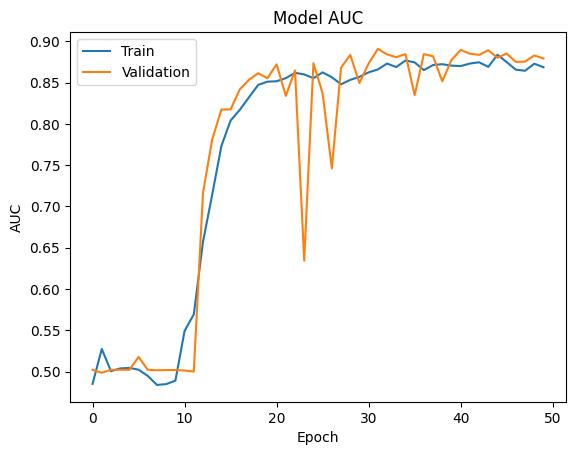

In [49]:
# Plot training & validation AUC values
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()